In [35]:
import xarray as xr
import cdsapi
import os
import matplotlib.pyplot as plt
import numpy as np


In [21]:
var_names = ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
            'mean_sea_level_pressure', 'sea_surface_temperature', 'surface_net_solar_radiation',
            'surface_net_thermal_radiation']

years = ['1950']

months = [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12'
        ]

save_directory = '/scratch/groups/earlew/yuchen/ERA5'

# test retrieval of ERA5 data 
def download_era5_variable(var_name, save_path, plevel=None, overwrite=False):
    if os.path.exists(save_path):
        if overwrite: 
            print(f'{save_path} already exists! Overwriting...\n')
        else:
            print(f'{save_path} already exists! Skipping...\n')
            return
    
    retrieval_info = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': var_name,
        'year': years,
        'month': months,
        'time': '00:00',
        'format': 'netcdf'
    }

    if plevel is not None:
        dataset = 'reanalysis-era5-pressure-levels-monthly-means'
        retrieval_info['pressure_level'] = plevel
        print(f'Downloading {var_name} at pressure lev {plevel} and saving to {save_path}')
    else: 
        dataset = 'reanalysis-era5-single-levels-monthly-means'
        print(f'Downloading {var_name} and saving to {save_path}')

    cds_client.retrieve(dataset, retrieval_info, save_path)

cds_client = cdsapi.Client()

# test on one variable
var_to_save = var_names[0]
save_path = os.path.join(save_directory, '{}_TEST.nc'.format(var_to_save))
download_era5_variable(var_to_save, save_path)

2024-07-09 11:08:06,138 INFO Welcome to the CDS
2024-07-09 11:08:06,138 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2024-07-09 11:08:06,335 INFO Request is queued
2024-07-09 11:08:07,502 INFO Request is running
2024-07-09 11:08:11,589 INFO Request is completed
2024-07-09 11:08:11,590 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars.internal-1720548490.1008224-2089-12-004c7a17-37bb-414a-8722-7ec8d86a5314.nc to /scratch/groups/earlew/yuchen/ERA5/10m_u_component_of_wind_TEST.nc (23.8M)
2024-07-09 11:08:19,277 INFO Download rate 3.1M/s   


In [2]:
var_names = ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
            'mean_sea_level_pressure', 'sea_surface_temperature', 'surface_net_solar_radiation',
            'surface_net_thermal_radiation']

for var_name in var_names:
    print(f'python3 download_era5_data.py --var {var_name} > logs/era5_download_logs/{var_name}.txt 2>&1 &')

python3 download_era5_data.py --var 10m_u_component_of_wind > logs/era5_download_logs/10m_u_component_of_wind.txt 2>&1 &
python3 download_era5_data.py --var 10m_v_component_of_wind > logs/era5_download_logs/10m_v_component_of_wind.txt 2>&1 &
python3 download_era5_data.py --var 2m_temperature > logs/era5_download_logs/2m_temperature.txt 2>&1 &
python3 download_era5_data.py --var mean_sea_level_pressure > logs/era5_download_logs/mean_sea_level_pressure.txt 2>&1 &
python3 download_era5_data.py --var sea_surface_temperature > logs/era5_download_logs/sea_surface_temperature.txt 2>&1 &
python3 download_era5_data.py --var surface_net_solar_radiation > logs/era5_download_logs/surface_net_solar_radiation.txt 2>&1 &
python3 download_era5_data.py --var surface_net_thermal_radiation > logs/era5_download_logs/surface_net_thermal_radiation.txt 2>&1 &


# Code to test regridding script

In [155]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe 
import os
import config
import importlib

In [6]:
ds = xr.open_dataset('/scratch/groups/earlew/yuchen/NSIDC/seaice_conc_monthly_sh_200810_f17_v04r00.nc')
ds

<xarray.Dataset>
Dimensions:                           (tdim: 1, y: 332, x: 316)
Coordinates:
    time                              (tdim) datetime64[ns] ...
    xgrid                             (x) float32 ...
    ygrid                             (y) float32 ...
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (tdim, y, x) float32 ...
    nsidc_bt_seaice_conc_monthly      (tdim, y, x) float32 ...
    nsidc_nt_seaice_conc_monthly      (tdim, y, x) float32 ...
    projection                        |S1 ...
    qa_of_cdr_seaice_conc_monthly     (tdim, y, x) float32 ...
    stdev_of_cdr_seaice_conc_monthly  (tdim, y, x) float32 ...
Attributes: (12/42)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2021-06-22T16:44:10Z
    time_coverage_start:       2008-10-01T00:00:00Z
    time_coverage_end:         2008-10-31T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

In [165]:
era5_vars = ['2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind',
            'mean_sea_level_pressure', 'sea_surface_temperature', 'surface_net_solar_radiation',
            'surface_net_thermal_radiation']

for variable in era5_vars:
    ds = xr.open_dataset(f'{config.DATA_DIRECTORY}/ERA5/{variable}.nc')
    for var in ds.data_vars:
        print(f"{variable}: {var}")

2m_temperature: t2m
10m_u_component_of_wind: u10
10m_v_component_of_wind: v10
mean_sea_level_pressure: msl
sea_surface_temperature: sst
surface_net_solar_radiation: ssr
surface_net_thermal_radiation: str


In [122]:
nsidc_sps_grid = xr.open_dataset(f'{config.DATA_DIRECTORY}/NSIDC/nsidc_CDR_southerngrid.nc')
nsidc_sps_grid = nsidc_sps_grid.rename({"latitude": "lat", "longitude": "lon"})

In [133]:
test_data = xr.open_dataset(f'{config.DATA_DIRECTORY}/ERA5/2m_temperature.nc')
test_data = test_data.t2m.isel(time=-1, expver=1)
test_data = test_data.rename({"latitude": "lat", "longitude": "lon"})

In [145]:
weight_file = f'test_weights.nc'

if os.path.exists(weight_file):
    regridder = xe.Regridder(test_data, nsidc_sps_grid, 'bilinear', filename=weight_file, 
                            ignore_degenerate=True, reuse_weights=True, periodic=True)
else:
    regridder = xe.Regridder(test_data, nsidc_sps_grid, 'bilinear', filename=weight_file, 
                            ignore_degenerate=True, reuse_weights=False, periodic=True)

ds_regridded = regridder(test_data)

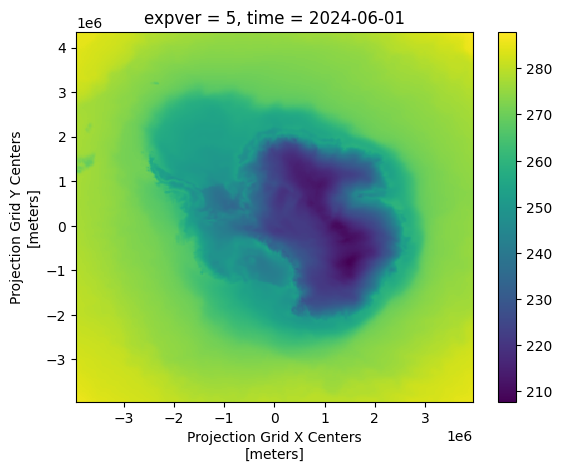

In [146]:
ds_regridded.plot()

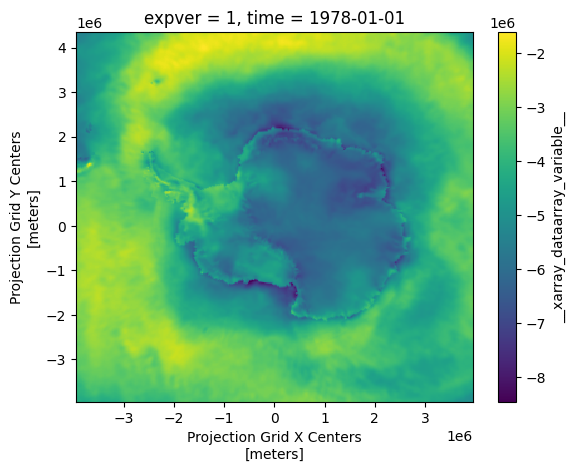

: 

In [171]:
xr.open_dataset(f'{config.DATA_DIRECTORY}/ERA5/surface_net_thermal_radiation_SPS.nc')['__xarray_dataarray_variable__'].isel(time=0, expver=0).plot()